In [13]:
import napari
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from napari.utils import nbscreenshot
from skimage import morphology
from scipy import signal
from skimage.measure import label, regionprops_table

from napari_signal_selector.interactive import InteractiveFeaturesLineWidget

In [2]:
seed = 42
np.random.seed(seed)

## Generate signals

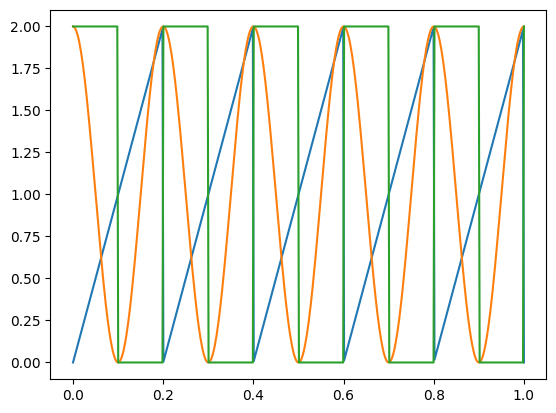

In [3]:
freq=5
time = np.linspace(0, 1, 500)
sawtooth = signal.sawtooth(2*np.pi*freq*time) + 1
cosine = np.cos(2*np.pi*freq*time) + 1
pulses = signal.square(2*np.pi*freq*time) + 1

signals = [cosine, pulses, sawtooth]

plt.plot(time, sawtooth)
plt.plot(time, cosine)
plt.plot(time, pulses)

## Generate objects

In [4]:
disk = morphology.disk(4)

square = morphology.square(9)
square[square==1] = 2

diamond = morphology.diamond(4)
diamond[diamond==1] = 3

objects_list = [disk, square, diamond]

## Generate label image

In [5]:
image = np.zeros((100, 100))
object_order = []
for i in range(10):
    for j in range(3):
        n = np.random.randint(low=0, high=3, size=1)[0]
        obj = objects_list[n]
        image[i*10: i*10+9, 20 + j*20 :20 + j*20 + 9] = obj
        object_order.append(n)

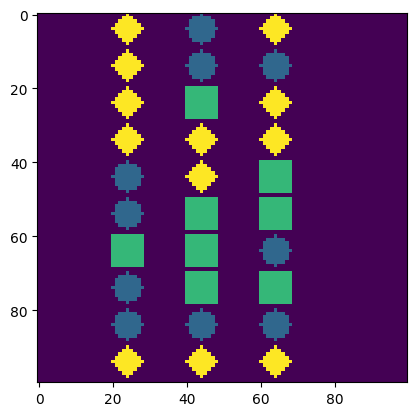

In [6]:
plt.imshow(image)

## Add signals to image with labels

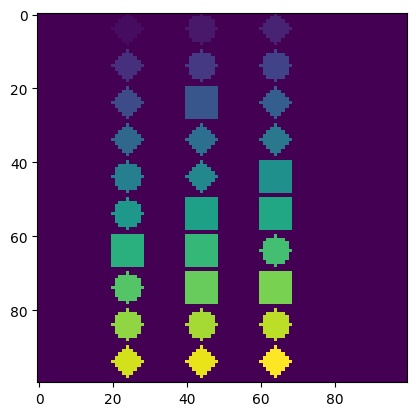

In [7]:
label_image = label(image)
plt.imshow(label_image)

In [8]:
height, width = image.shape
time_points = time.shape[0]
time_lapse = np.zeros((time_points, height, width))
for i in range(label_image.max()):
    mask = (label_image == i+1) # create boolean mask for current label
    signal = signals[object_order[i]]  # get corresponding signal for current label
    # Add random noise
    signal = signal + np.random.random(size=len(signal)) / 10
    # Add random offset
    signal = signal + np.random.random()*5
    time_lapse[:,mask] = signal.reshape((time_points, -1)) # assign signal to region corresponding to current label

## Measure intensities over time

In [9]:
df = pd.DataFrame([])
for i in range(time_points):
    features = pd.DataFrame(regionprops_table(label_image, intensity_image=time_lapse[i], properties=('label', 'mean_intensity')))
    features['frame'] = i
    # Reorder columns
    features = features[['label', 'frame', 'mean_intensity']]
    df = pd.concat([df, features])
df.head(8)

,label,frame,mean_intensity
0,1,0,1.918404
1,2,0,6.718972
2,3,0,0.604210
3,4,0,2.142554
4,5,0,3.419815
5,6,0,6.743313
6,7,0,3.860636
7,8,0,5.786531


## Add images to napari

In [10]:
viewer = napari.Viewer()
viewer.add_image(time_lapse, name='time_lapse')
viewer.add_labels(label_image, name='labels_image', features=df)

<Labels layer 'labels_image' at 0x1d2aa3de3a0>

In [11]:
plotter_widget = InteractiveFeaturesLineWidget(viewer)
viewer.window.add_dock_widget(plotter_widget)

Select 'label' for `object_id`, 'frame' for `x-axis` and 'mean_intensity' for `y-axis`.

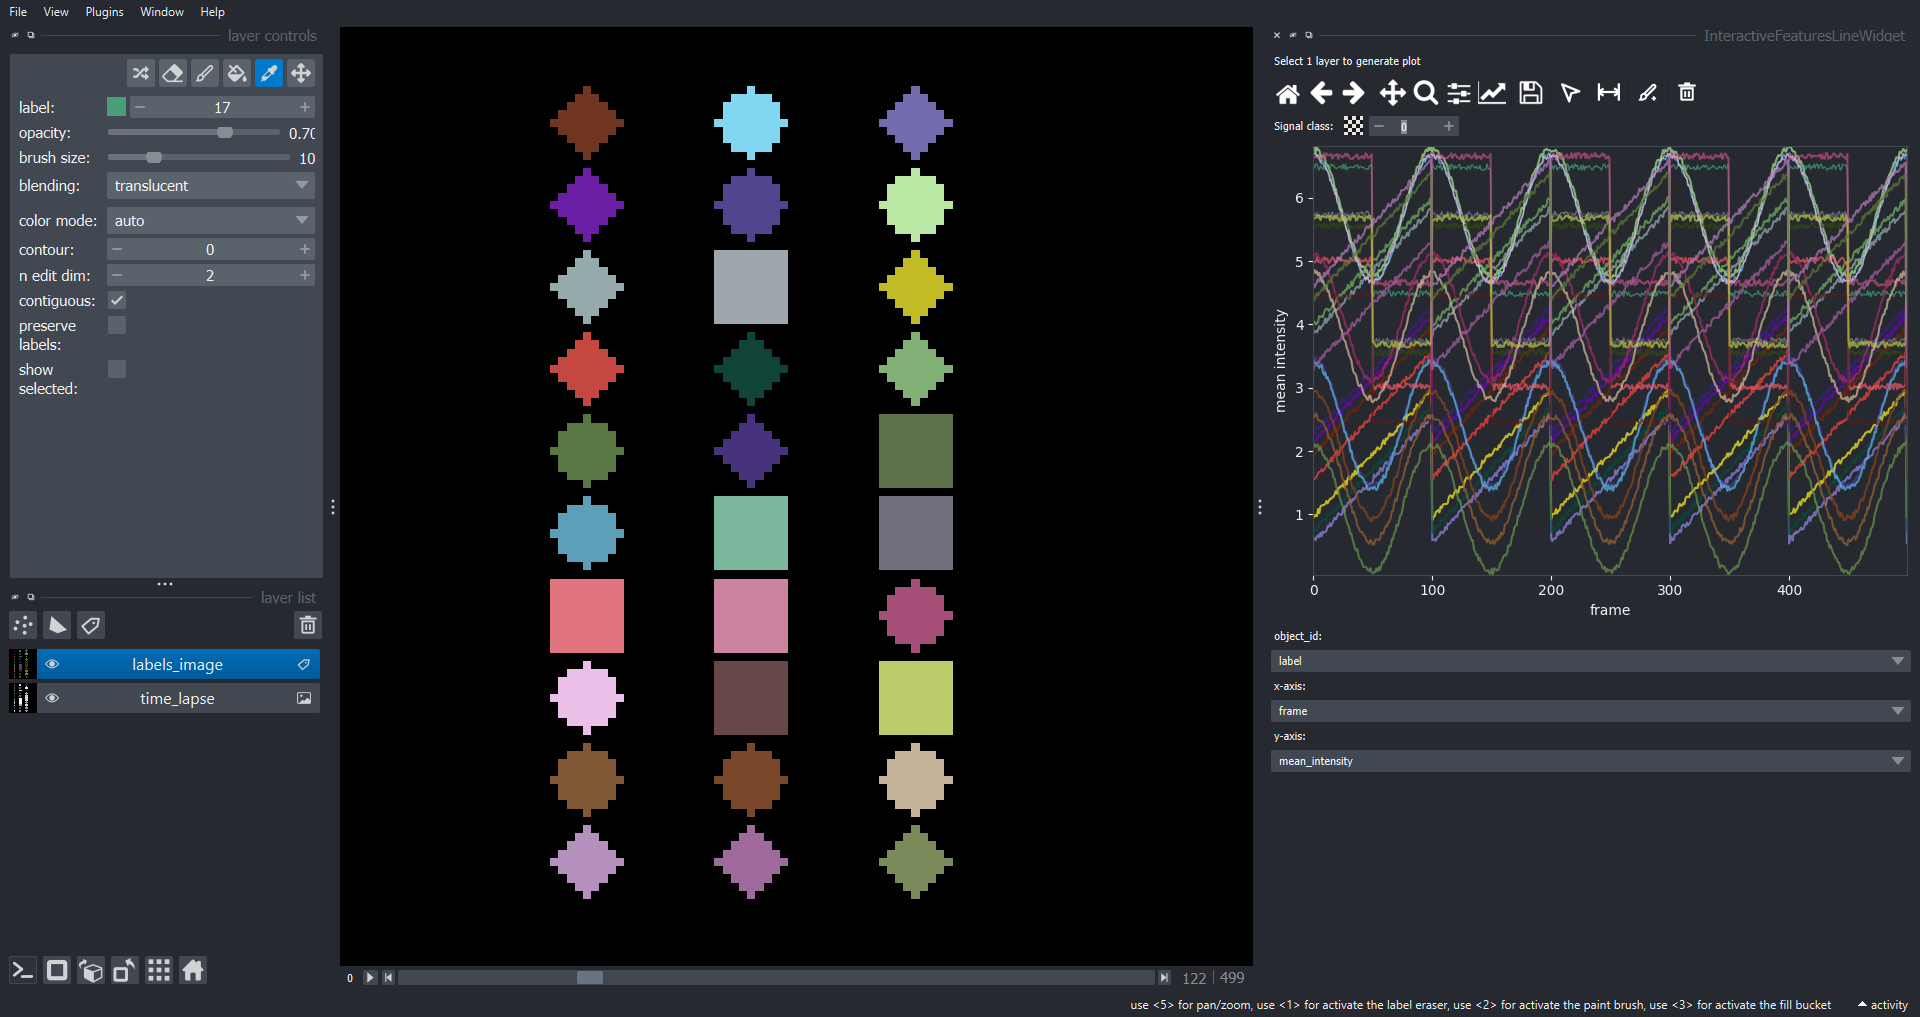

In [14]:
nbscreenshot(viewer)